In [16]:
import pydicom
import matplotlib.pyplot as plt
import numpy as np 
from monai.transforms import GaussianSmooth
import torch
from skimage.restoration import denoise_nl_means, estimate_sigma, denoise_wavelet
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from skimage import img_as_float

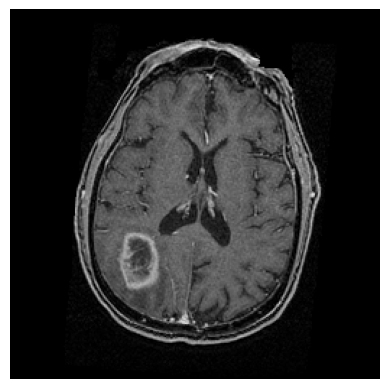

In [2]:
data = pydicom.dcmread("tciaDownload/1.3.6.1.4.1.14519.5.2.1.269607322454961545178354587485557855557/1-070.dcm")
img = data.pixel_array
plt.imshow(img, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

In [3]:
def add_noise_to_dicom(img, noise_type='gaussian', noise_level=0.6):
    noisy_img = img.copy()
    
    if noise_type == 'gaussian':
        noise = np.random.normal(0, noise_level, img.shape)
        noisy_img = img + noise
        noisy_img = np.clip(noisy_img, img.min(), img.max())
        
    elif noise_type == 'salt_pepper':
        salt_mask = np.random.random(img.shape) < (noise_level / 2)
        pepper_mask = np.random.random(img.shape) < (noise_level / 2)
        noisy_img[salt_mask] = img.max()
        noisy_img[pepper_mask] = img.min()
        
    elif noise_type == 'speckle':
        noise = np.random.normal(1, noise_level, img.shape)
        noisy_img = img * noise
        noisy_img = np.clip(noisy_img, img.min(), img.max())
    
    return noisy_img

In [4]:
def denoise_dicom_with_monai(img, sigma=5.0):
    img_tensor = torch.from_numpy(img).unsqueeze(0).unsqueeze(0).float()
    gaussian_smoother = GaussianSmooth(sigma=sigma)
    denoised_tensor = gaussian_smoother(img_tensor)
    return denoised_tensor.squeeze().cpu().numpy()

In [5]:
def denoise_dicom_with_skimage(img):
    img = img_as_float(img)
    sigma_est = np.mean(estimate_sigma(img, channel_axis=None))
    
    denoised = denoise_nl_means(
        img,
        h=1.5 * sigma_est,            
        fast_mode=False,             
        patch_size=7,                 
        patch_distance=15,           
        channel_axis=None
    )
    return denoised

In [6]:
noisy_img = add_noise_to_dicom(img, noise_type='speckle', noise_level=0.3)

denoised_monai = denoise_dicom_with_monai(noisy_img, sigma=5.0)
denoised_skimage = denoise_dicom_with_skimage(noisy_img)

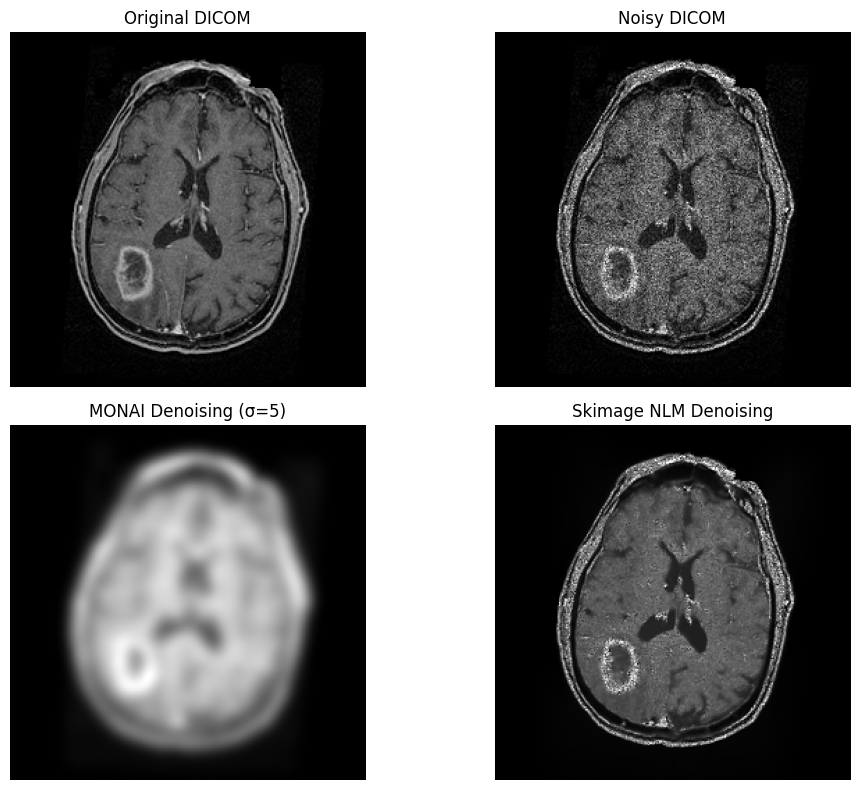

In [7]:
plt.figure(figsize=(15, 8))

plt.subplot(231)
plt.imshow(img, cmap='gray')
plt.title('Original DICOM')
plt.axis('off')

plt.subplot(232)
plt.imshow(noisy_img, cmap='gray')
plt.title('Noisy DICOM')
plt.axis('off')

plt.subplot(234)
plt.imshow(denoised_monai, cmap='gray')
plt.title('MONAI Denoising (σ=5)')
plt.axis('off')

plt.subplot(235)
plt.imshow(denoised_skimage, cmap='gray')
plt.title('Skimage NLM Denoising')
plt.axis('off')

plt.tight_layout()
plt.show()


### Evaluation

In [28]:
def calculate_metrics(original, denoised):
    """Calculate PSNR and SSIM metrics between original and denoised images"""
    
    original_float = img_as_float(original)
    denoised_float = img_as_float(denoised)
    
    psnr = peak_signal_noise_ratio(original_float, denoised_float, data_range=original_float.max() - original_float.min())
    
    ssim = structural_similarity(original_float, denoised_float, data_range=original_float.max() - original_float.min())
    
    return {'PSNR': psnr, 'SSIM': ssim}

In [29]:
def evaluate(img, noise_type='speckle', noise_level=0.03, monai_sigma=3.0):
    
    noisy_img = add_noise_to_dicom(img, noise_type=noise_type, noise_level=noise_level)
    
    denoised_monai = denoise_dicom_with_monai(noisy_img, sigma=monai_sigma)
    denoised_skimage = denoise_dicom_with_skimage(noisy_img)
    
    noise_metrics = calculate_metrics(img, noisy_img)
    monai_metrics = calculate_metrics(img, denoised_monai)
    skimage_metrics = calculate_metrics(img, denoised_skimage)
    
    metrics_monai = {
        'noise_psnr': noise_metrics['PSNR'],
        'noise_ssim': noise_metrics['SSIM'],
        'denoised_psnr': monai_metrics['PSNR'],
        'denoised_ssim': monai_metrics['SSIM'],
        'psnr_improvement': monai_metrics['PSNR'] - noise_metrics['PSNR'],
        'ssim_improvement': monai_metrics['SSIM'] - noise_metrics['SSIM']
    }
    
    metrics_skimage = {
        'noise_psnr': noise_metrics['PSNR'],
        'noise_ssim': noise_metrics['SSIM'],
        'denoised_psnr': skimage_metrics['PSNR'],
        'denoised_ssim': skimage_metrics['SSIM'],
        'psnr_improvement': skimage_metrics['PSNR'] - noise_metrics['PSNR'],
        'ssim_improvement': skimage_metrics['SSIM'] - noise_metrics['SSIM']
    }
    
    # Print metrics
    print(f"Noise Type: {noise_type}, Noise Level: {noise_level}")
    print(f"Noisy Image - PSNR: {noise_metrics['PSNR']:.2f}, SSIM: {noise_metrics['SSIM']:.4f}")
    print(f"MONAI Denoising - PSNR: {monai_metrics['PSNR']:.2f}, SSIM: {monai_metrics['SSIM']:.4f}")
    print(f"MONAI Improvement - PSNR: {metrics_monai['psnr_improvement']:.2f}, SSIM: {metrics_monai['ssim_improvement']:.4f}")
    print(f"Skimage Denoising - PSNR: {skimage_metrics['PSNR']:.2f}, SSIM: {skimage_metrics['SSIM']:.4f}")
    print(f"Skimage Improvement - PSNR: {metrics_skimage['psnr_improvement']:.2f}, SSIM: {metrics_skimage['ssim_improvement']:.4f}")
    
    return {
        'metrics': {
            'noise': noise_metrics,
            'monai': monai_metrics,
            'skimage': skimage_metrics
        }
    }

In [31]:
result = evaluate(img, noise_type='speckle', noise_level=0.1, monai_sigma=2.0)

Noise Type: speckle, Noise Level: 0.1
Noisy Image - PSNR: 32.64, SSIM: 0.9407
MONAI Denoising - PSNR: 14.39, SSIM: 0.4876
MONAI Improvement - PSNR: -18.26, SSIM: -0.4532
Skimage Denoising - PSNR: 33.65, SSIM: 0.9086
Skimage Improvement - PSNR: 1.01, SSIM: -0.0321
